In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import xgboost as xgb
from catboost import CatBoostRegressor
import lightgbm as lgb
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
df = pd.read_csv("preprocessed_data.csv")

In [3]:
# Scale numeric columns (e.g., Area)
area_scaler = StandardScaler()
df['Area (sqft)'] = area_scaler.fit_transform(df[['Area (sqft)']])

# Save the scaler
with open('area_scaler.pkl', 'wb') as scaler_file:
    pickle.dump(area_scaler, scaler_file)

In [4]:
# Define features (X) and target (y)
X = df[['Area (sqft)', 'BHK', 'Bathrooms', 'Construction Status', 'City', 'Location_encoded']]
y = df['Price']

In [5]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Custom scorers
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

In [7]:
# Store results
results = {}

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
results['Linear Regression'] = {
    'Best Params': None,
    'MAE': mean_absolute_error(y_test, y_pred_lr),
    'R2': r2_score(y_test, y_pred_lr)
}

In [8]:
# Parameter grids
# Decision Tree Regressor
dt_param_dist = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [2, 5]
}

# Random Forest Regressor
rf_param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'bootstrap': [True]
}

# Gradient Boosting Regressor
gb_param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.01],
    'subsample': [0.8, 1.0]
}

# SVR
svr_param_dist = {
    'C': [1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale']
}

# KNN Regressor
knn_param_dist = {
    'n_neighbors': [5, 10],
    'weights': ['uniform']
}

# XGBoost Regressor
xgb_param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [5, 10],
    'learning_rate': [0.05, 0.01],
    'subsample': [0.8, 1.0]
}

# CatBoost Regressor
cat_param_grid = {
    'iterations': [200, 500],
    'depth': [6, 10],
    'learning_rate': [0.05, 0.01],
    'l2_leaf_reg': [3, 5]
}

# LightGBM Regressor
lgb_param_grid = {
    'n_estimators': [200, 500],
    'num_leaves': [31, 50],
    'learning_rate': [0.05, 0.01],
    'max_depth': [10, 20],
    'subsample': [0.8, 1.0]
}


In [9]:
# Helper function for RandomizedSearchCV
def random_search_cv(model, param_dist, X_train, y_train, X_test, y_test, model_name):
    search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=50, cv=5, 
                                scoring='neg_mean_absolute_error', random_state=42, n_jobs=-1)
    search.fit(X_train, y_train)
    y_pred = search.predict(X_test)
    results[model_name] = {
        'Best Params': search.best_params_,
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }

In [10]:
# Decision Tree
random_search_cv(DecisionTreeRegressor(random_state=42), dt_param_dist, X_train, y_train, X_test, y_test, 'Decision Tree')

In [12]:
# Random Forest
random_search_cv(RandomForestRegressor(random_state=42), rf_param_grid, X_train, y_train, X_test, y_test, 'Random Forest')

In [13]:
# Gradient Boosting
random_search_cv(GradientBoostingRegressor(random_state=42), gb_param_grid, X_train, y_train, X_test, y_test, 'Gradient Boosting')

In [14]:
# SVR
random_search_cv(SVR(), svr_param_dist, X_train, y_train, X_test, y_test, 'SVR')

In [15]:
# KNN
random_search_cv(KNeighborsRegressor(), knn_param_dist, X_train, y_train, X_test, y_test, 'KNN')

In [16]:
# XGBoost
random_search_cv(xgb.XGBRegressor(random_state=42), xgb_param_grid, X_train, y_train, X_test, y_test, 'XGBoost')

In [17]:
# CatBoost
random_search_cv(CatBoostRegressor(random_state=42, verbose=0), cat_param_grid, X_train, y_train, X_test, y_test, 'CatBoost')

In [18]:
# LightGBM
random_search_cv(lgb.LGBMRegressor(random_state=42), lgb_param_grid, X_train, y_train, X_test, y_test, 'LightGBM')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 471
[LightGBM] [Info] Number of data points in the train set: 57674, number of used features: 6
[LightGBM] [Info] Start training from score 14464733.276693


In [19]:
# Convert results to DataFrame and display
results_df = pd.DataFrame(results).T
print(results_df)

# Save results to CSV
results_df.to_csv('model_results.csv', index=True)

                                                         Best Params  \
Linear Regression                                                NaN   
Decision Tree      {'min_samples_split': 10, 'min_samples_leaf': ...   
Random Forest      {'n_estimators': 300, 'min_samples_split': 5, ...   
Gradient Boosting  {'subsample': 1.0, 'n_estimators': 300, 'max_d...   
SVR                  {'kernel': 'linear', 'gamma': 'scale', 'C': 10}   
KNN                         {'weights': 'uniform', 'n_neighbors': 5}   
XGBoost            {'subsample': 1.0, 'n_estimators': 300, 'max_d...   
CatBoost           {'learning_rate': 0.05, 'l2_leaf_reg': 3, 'ite...   
LightGBM           {'subsample': 0.8, 'num_leaves': 50, 'n_estima...   

                              MAE        R2  
Linear Regression   6941788.95316  0.500378  
Decision Tree      3015713.868421  0.809934  
Random Forest      2546415.826799  0.871639  
Gradient Boosting  3283848.358867  0.860169  
SVR                7739024.631627   -0.0348  
KNN

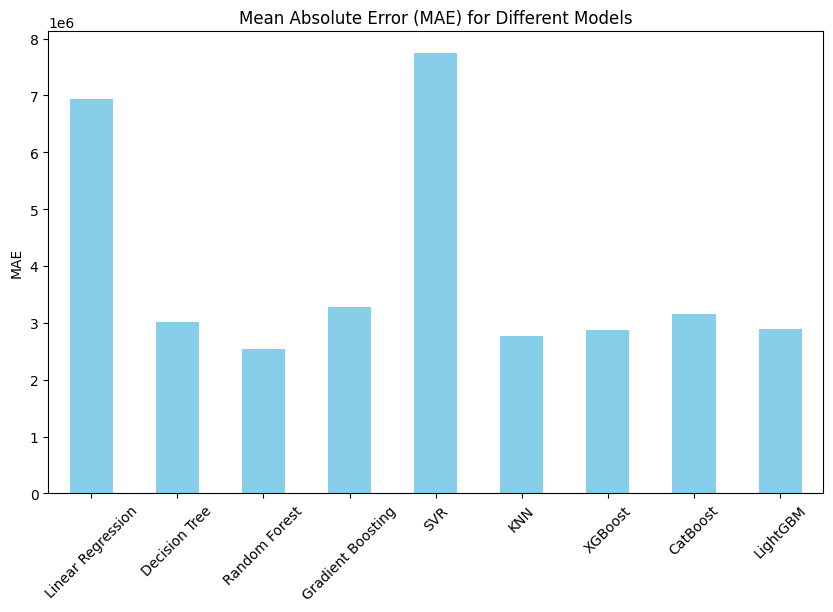

In [20]:
# Plot MAE
plt.figure(figsize=(10, 6))
results_df['MAE'].plot(kind='bar', color='skyblue')
plt.title('Mean Absolute Error (MAE) for Different Models')
plt.ylabel('MAE')
plt.xticks(rotation=45)
plt.show()

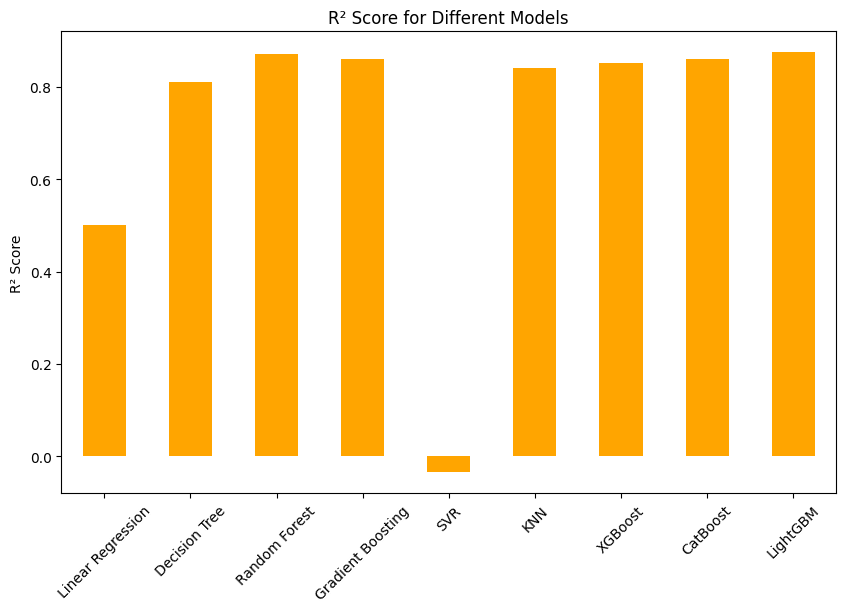

In [21]:
# Plot R²
plt.figure(figsize=(10, 6))
results_df['R2'].plot(kind='bar', color='orange')
plt.title('R² Score for Different Models')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
plt.show()